# LAST YEAR PROJECT

In [1]:
# Importing required packages
import gzip
import os
import pickle
#!pip install pickle5
#import pickle5 as pickle # windows python 3.7.6 not supporting Protocol 5

import copy
import random
import pandas as pd
import time

# for processing
import re
#!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

import time
import math
from datetime import datetime

import numpy as np

from sklearn import feature_selection, feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# for bag-of-words

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Twitter Scraper library
#!pip install git+https://github.com/JustAnotherArchivist/snscrape.git
import snscrape.modules.twitter as sntwitter
#!pip install flair
import flair

The following Class (**Data**) is responsible for loading the data (Companies with their corresponding 8k reports) in an interpretable format.

In [ ]:
class Data():
    '''
    This class loads, and organises the data in a way that it can be manipulated in a desired manner.
    '''
    
    def __init__(self):
        self._8k_reports = {}
        self._8k_r_path = 'data/8K-gz/'
        self.load_data()
        self.separate_reports()
    
    def load_data(self):
        '''
        Fill dictionary with company symbols as keys and their respective reports (byte objects) as values.
        '''
        #if os.path.isfile('data/separate_reports.pickle'):
            #with open('data/separate_reports.pickle', 'rb') as handle:
                #self._8k_reports = pickle.load(handle)
        #else:
        symbols = [f for f in os.listdir(self._8k_r_path) if not f.startswith('.')]
        #symbols = [s.replace('._', '') for s in symbols] #Only when using windows
        for symbol in symbols:
            directory = self._8k_r_path + symbol
            #print(directory, symbol)
            #print(symbol.replace('.gz',''))
            with gzip.open(directory, 'rb') as f:
                self._8k_reports[symbol.replace('.gz','')] = f.read()
            
            #with open('data/raw_data.pickle', 'wb') as handle:
                #pickle.dump(self._8k_reports, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
    def separate_reports(self):
        '''
        Replace the dictionary values from byte object reports to a list of unique/separate string reports.
        '''
        #if os.path.isfile('data/separate_reports.pickle') == False:
        companies = []
        report_list = []
        for (symbol, reports) in self._8k_reports.items():
            # Separate reports by the '</DOCUMENT>' delimiter and remove the last item of the list (\\n').
            reports_list = str(reports).split('</DOCUMENT>')
            reports_list.pop(-1)
            self._8k_reports[symbol] = reports_list
            for report in reports_list:
                companies.append(symbol)
                report_list.append(report)
        self.dataframe(companies, report_list)    
                
            #with open('data/separate_reports.pickle', 'wb') as handle:
                #pickle.dump(self._8k_reports, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
    def dataframe(self, companies, reports):        
        self.df_data = pd.DataFrame({'company':companies, 'report': reports})


In [ ]:
data = Data()
data.df_data

**Counting number of 8-k reports**

In [ ]:
print('Total number of 8k reports: ', len(data.df_data))

## 8k report categories

In [2]:
# New classification
report_categories = ['Entry into a Material Definitive Agreement',
'Termination of a Material Definitive Agreement',
'Mine Safety - Reporting of Shutdowns and Patterns of Violations',
#----------
'Completion of Acquisition or Disposition of Assets',
'Results of Operations and Financial Condition',
'Creation of a Direct Financial Obligation or an Obligation under an Off-Balance Sheet Arrangement of a Registrant',
'Triggering Events That Accelerate or Increase a Direct Financial Obligation or an Obligation under an Off-Balance Sheet Arrangement',
'Costs Associated with Exit or Disposal Activities',
'Material Impairments',
#----------
'Notice of Delisting or Failure to Satisfy a Continued Listing Rule or Standard; Transfer of Listing',
'Unregistered Sales of Equity Securities',
'Material Modification to Rights of Security Holders',
#----------
'Non-Reliance on Previously Issued Financial Statements or a Related Audit Report or Completed Interim Review',
#----------
'Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers; Compensatory Arrangements of Certain Officers',
'Departure of Directors or Principal Officers; Election of Directors; Appointment of Principal Officers',
'Amendments to Articles of Incorporation or Bylaws; Change in Fiscal Year',
'Amendment to Registrant\\\'s Code of Ethics, or Waiver of a Provision of the Code of Ethics',
'Change in Shell Company Status',
'Submission of Matters to a Vote of Security Holders',
'Shareholder Director Nominations',
#-----------
'ABS Informational and Computational Material',
'Change of Servicer or Trustee',
'Change in Credit Enhancement or Other External Support',
'Failure to Make a Required Distribution',
'Securities Act Updating Disclosure',
#-----------
'Regulation FD Disclosure',
#-----------
'Other Events (The registrant can use this Item to report events that are not specifically called for by Form 8-K, that the registrant considers to be of importance to security holders.)',
#-----------
'Financial Statements and Exhibits', 
# Old categorisation
'Changes in Control of Registrant',
'Acquisition or Disposition of Assets',
'Bankruptcy or Receivership',
'Changes in Registrant\\\'s Certifying Accountant',
'Other Events',
'Other events',
'Resignation of Registrant\\\'s Directors',
'Change in Fiscal Year',
'Amendments to the Registrant\\\'s Code of Ethics',
'Temporary Suspension of Trading Under Registrant\\\'s Employee Benefit Plans']


### Feature preprocessing (without Non-negative matrix factorisation)

**Non-linguistic features (3):**
1. Normalised price changes (UP: 1, DOWN: -1, STAY: 0)
2. Moving averages
3. Volatility index
- Earnings surprise - **Not used because it limits the ability to comprehend how effective the NLP techniques and ML models are to predict since this feature is highly informative of the price direction.** We want to be able to predict price movements of any type of reports and not just those ones mentioning earnings surprise.

**Linguistic features:**
- Event category (the reason for filing the form 8-K)
- Reports Polarity score (Positive or Negative)
- EXPLAIN BETTER - TD-IDF

Import historical prices of S&P500 as there is data found all the way from 2002 (Unlike S&P1500 which is only found from the year 2008). This index still provides a good notion of how the market is performing overall, thus can be used to normalise stock prices. 

In [3]:
class Preprocess():
    '''
    This class...
    '''
    def __init__(self, data, report_categories):
        self.data = data # raw data
        self.sp500_hist_prices = pd.read_csv("data/sp500_prices.csv") # S&P 500 Historical prices
        self.VIX = pd.read_csv("data/VIX.csv").sort_values(['Date'], ascending=False) # S&P 500 volatility prices
        self.lexicons_dic = {}
        self.sentiment_lexicons() # Load csv file containing Financial words scored and add positive and negative words to lexicons_dic
        self.reports_polarity_score = []
        self.preprocessed_reports = [] # All the reports in a clean format
        self.tfidf = [] # TF-IDF values of all reports
        self.report_categories = report_categories # all possible categories a report can be classified as
        self.df_dates_categories = pd.DataFrame(columns=['company','report date','event category'])
        self.normalised_price_change = {} # Normalised companies' price changes after 8k doc release
        self.recent_movements = {} # Companies recent price movements (1 week, monthly, quartely and yearly)
        self.volatility = {} # Index volatily before a report is submitted   
        self.negation_heuristic = False
        self.linguistic_models = {}
        self.df_prep_data = pd.DataFrame(columns=['company','preprocessed report','date','report polarity','categories','week move','month move','quarter move','year move','volatility','price direction'])

        
    def reports_date_categories(self):
        '''
        Perform a general analysis of the 8k reports from a given company and return the correspondent date stamps
        of each report, along with the event categories of each.
        '''
        date_stamp = None
        event_categories = []
        for index, row in self.data.iterrows():
            dic = {}
            report = row['report']
            company = row['company']
            match = re.search(r"TIME:(\d+)\\", report) # Regex expression --> TIME:YYYMMDDHHMMSS\\
            match = report[match.span()[0]+5:match.span()[1]-7] # Only keep --> YYYYMMDD
            file_path = 'data/price_history/' + company + '.csv' # Load the csv named after the parameter company to extract prices
            company_prices = pd.read_csv(file_path) # Load the company's historical prices
            temp_date = datetime.strptime(match, '%Y%m%d').strftime('%Y-%m-%d')
            if temp_date in company_prices.Date.values:
                dic['company']=company
                dic['date']=temp_date
                categ = [] # List of categories for each report
                for category in self.report_categories:
                    categ_match = re.search(category, report)
                    if categ_match is not None:
                        categ.append(categ_match.group())
                if len(categ) == 0:
                    dic['categories']=['Unknown']
                else:
                    dic['categories']=categ
            else: 
                dic['company']=company
                dic['categories']=['Unknown']
                dic['date']=None
            self.df_dates_categories = self.df_dates_categories.append(dic, ignore_index=True)
  
    
    def load_file(self, file_name, file_format = '.pickle'):
        print('Loading file:', file_name, file_format, '...')
        file_path = 'data/' + file_name + file_format
        with open(file_path, 'rb') as handle:
            file = pickle.load(handle)
        return file
    
    def save_file(self, file_name, saving_var, file_format = '.pickle'):
        print('Saving file:', file_name, file_format, '...')
        file_path = 'data/' + file_name + file_format
        with open(file_path, 'wb') as handle:
            pickle.dump(saving_var, handle, protocol=pickle.HIGHEST_PROTOCOL) 
            
        
    def sentiment_lexicons(self):
        '''
        Custom dictionary of negative and positive words specific to the accounting and financial domain obtained
        from the Loughran and McDonald (2011) article.
        SENTIMENT LEXICONS (POLARITY: NEGATIVE OR POSITIVE)
        '''
        # These sentiment lexicons lack a scoring measurement 
        lexicons = pd.read_csv('data/LoughranMcDonald_MasterDictionary_2018.csv')
        lexicons = lexicons[['Word','Negative','Positive']]
        lexicons.drop(lexicons[(lexicons.Negative == 0) & (lexicons.Positive == 0)].index, inplace=True)
        neg, pos = [], []
        for index, row in lexicons.iterrows():
            if row['Negative'] != 0:
                neg.append(row['Word'].lower())
            else:
                pos.append(row['Word'].lower())
        self.lexicons_dic['Positive'] = pos
        self.lexicons_dic['Negative'] = neg
    
    def sentiment_score(self, token_list):
        '''
        This function uses the Loughran and McDonald list of financial domain-specific words classified as positive
        or negative. However, due to the scarce number of pos (354) and neg (354) words, this function also obtains
        sentiment scores from the SentiWordNet if a given word is not found of the previous dictionary. In addition,
        the function takes into account words that have been negated by giving them an opposite scored to the one obtained (if any).
        Negative reports will generally have a greater tendency to be well represented by sentiment scores due to
        the wider list of domain-specific words available.
        '''
        score = 0
        for token in token_list:
            found_LM = False # Indicative of a word found in the financial sentiment lexicon dictionary
            negated_word = False
            if '_NEG' in token:
                token = re.sub('_NEG', '',token) # remove the '_NEG' tag to find the score of the actual word
                negated_word = True
            if token in self.lexicons_dic['Positive']:
                score += 0.5
                found_LM = True
            elif token in self.lexicons_dic['Negative']:
                score -= 0.5
                found_LM = True        
            if not found_LM and wn.synsets(token): # if the word is not found in LM dictionary, use SentiWordNet to get a score (if any)
                breakdown = swn.senti_synset(wn.synsets(token)[0].name())
                if breakdown.pos_score() > 0.5 and breakdown.neg_score() < 0.4:
                    score += 0.5
                elif breakdown.neg_score() > 0.5 and breakdown.pos_score() < 0.4:
                    score -= 0.5
            if negated_word:
                score = score * -1 # Provide negated score for negated words
        return score

                    
    def reports_polarity(self):
        '''
        Flattened list of the polarity of all the reports available.
        '''
        for index, row in self.data.iterrows():
            report = row['report']
            report_tks = self.report_tokens(report)
            self.reports_polarity_score.append(self.sentiment_score(report_tks))
            self.preprocessed_reports.append(report_tks) # add tokenized report to list, so after it can be used for get TF-IDF and VH values.

            
    def report_tokens(self, report):
        '''
        Incorporate a model of negation by marking as a negative every word appearing between a linguistic negation and a clause-level punctuation mark.
        All words are lemmatized. Removing special characters, and numbers, as well as making the entire report small case for processing purposes.
        '''
        report = re.sub('\\\\n', ' ', report)
        report = re.sub('\\\\t', ' ', report)
        report = re.sub("\\\\'", "'", report)
        report = report.lower()

        if self.negation_heuristic:
            # Negation heuristic
            temp_report = re.findall('(?:never|no |nothing|nowhere|noone|none|not|havent|hasnt|hadnt|cant|couldnt|shouldnt|wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)(.*?)[^\w\s]', report)
            # list of negated tokens (e.g. win_NEG) - to later add to unigram
            negated_tokens = [tk+'_NEG' for tr in temp_report for tk in word_tokenize(tr)]            
            # new report without the linguistic negations and the original negated tokens
            report = re.sub('(?:never|no |nothing|nowhere|noone|none|not|havent|hasnt|hadnt|cant|couldnt|shouldnt|wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)(.*?)[^\w\s]', '', report)
            temp_tokens = word_tokenize(report) + negated_tokens
        else:
            temp_tokens = word_tokenize(report)
            
        lemmatizer = WordNetLemmatizer() 
        stop = stopwords.words('english') # Remove English stop words
        tokens = []
        for tk in temp_tokens:
            lemmatized_tk = lemmatizer.lemmatize(tk)
            if lemmatized_tk.isalpha() and lemmatized_tk not in stop and wn.synsets(lemmatized_tk) or '_NEG' in lemmatized_tk:
                tokens.append(lemmatized_tk)
                
        return tokens

        
    def compute_others(self):
        '''
        Compute stock price, stock avg movements and volatility, price direction (up,stay,down) and add them 
        to a pandas dataframe plus the preprocessed reports, dates and categories.
        '''
        if os.path.isfile('data/df_prep_data.pkl'):
        # if directory has already been created, load pickle files into variables
            self.df_prep_data = pd.read_pickle("data/df_prep_data.pkl")
            self.df_dates_categories = pd.read_pickle("data/reports_date_cat.pkl")
            self.reports_polarity_score = self.load_file('reports_polarity')
            self.preprocessed_reports = self.load_file('preprocessed_reports')
        else:
            self.reports_date_categories()
            self.reports_polarity()
            for i, (index, row) in enumerate(self.df_dates_categories.iterrows()):
                dic = {}
                company = row['company']
                date = row['date']
                categories = row['categories']
                if date is not None:
                    file_path = 'data/price_history/' + company + '.csv' # Load the csv named after the parameter company to extract prices
                    company_prices = pd.read_csv(file_path) # Load the company's historical prices
                if date in company_prices.Date.values and date in self.sp500_hist_prices.Date.values: # Check if there is s&p500 data and companies' stock price from the date extracted in the 8k report
                    dic['company']=company
                    dic['preprocessed report']=self.preprocessed_reports[i]
                    dic['date']=date
                    dic['report polarity']=self.reports_polarity_score[i]
                    dic['categories']=categories
                    recent_moves = self.MA(company, date)
                    dic['week move']=recent_moves[0]
                    dic['month move']=recent_moves[1]
                    dic['quarter move']=recent_moves[2]
                    dic['year move']=recent_moves[3]
                    dic['volatility']=self.volatility_index(date)
                    dic['price direction']=self.normal_price_change(company, date)   
                self.df_prep_data = self.df_prep_data.append(dic, ignore_index=True)
            
            # Save and update dates and categories dataframe before one-hot-encoding
            self.df_dates_categories = self.df_prep_data[['company','categories','date']]
            self.df_dates_categories.to_pickle("data/reports_date_cat.pkl")
            # One-hot-encode the event categories of each report
            df1 = self.df_prep_data['categories'].explode()
            self.df_prep_data = self.df_prep_data[self.df_prep_data.columns].join(pd.crosstab(df1.index, df1))
            self.df_prep_data.pop('categories')
            # Delete all rows containing NaN values
            self.df_prep_data.dropna(inplace=True)
            # Save and update variables
            # New preprocessed reports list required to compute tf-idf values (some were removed as they contained NaN values)
            self.preprocessed_reports = self.df_prep_data['preprocessed report'].tolist()
            self.save_file(str('preprocessed_reports'), self.preprocessed_reports)
            self.reports_polarity_score = self.df_prep_data['report polarity'].tolist()
            self.save_file(str('reports_polarity'), self.preprocessed_reports)
            # Save Dataframe
            self.df_prep_data.to_pickle("data/df_prep_data.pkl")

            
    def normal_price_change(self, company, close_date):
        '''
        Compute the difference in the company’s stock price before and 2 days after the report is released. 
        For example, if the 8-K report is published before market opens, this difference is computed between the
        price at the 2 days after open and the price at the release date close. Normalize this difference by subtracting 
        the same difference computed for the entire S&P 1500 index (stock index GSPC) for the same period.
        '''        
        file_path = 'data/price_history/' + company + '.csv' # Load the csv named after the parameter company to extract prices
        company_prices = pd.read_csv(file_path) # Load the company's historical prices
        # Extract the values from columns *Close* and *Open* where the value in the column Date is equal to the variable **date**.
        
        adjclose_STOCK = company_prices.loc[company_prices["Date"] == close_date, ["Close"]].values.item() # Close price
        index = company_prices.loc[company_prices["Date"] == close_date].index[0] # index of Next day Open price date
        if index+2 < len(company_prices.index): 
            next2days_open_STOCK = company_prices.iloc[index+2]["Open"] # 2 days after Open price date
        else:
            return None
        
        diff_STOCK = next2days_open_STOCK - adjclose_STOCK # Calculate difference in STOCK price
        perc_change_STOCK = (abs(diff_STOCK)/adjclose_STOCK) * 100 # Calculate percentage change in STOCK price
        if diff_STOCK < 0: # Account for positive or negative percentage change in STOCK price
            perc_change_STOCK = perc_change_STOCK*-1 

        adjclose_SP500 = self.sp500_hist_prices.loc[self.sp500_hist_prices["Date"] == close_date, ["Close"]].values.item()
        index = self.sp500_hist_prices.loc[self.sp500_hist_prices["Date"] == close_date].index[0]                                            
        next2days_open_SP500 = self.sp500_hist_prices.iloc[index+2]["Open"]

        diff_SP500 = next2days_open_SP500 - adjclose_SP500
        perc_change_SP500 = (abs(diff_SP500)/adjclose_SP500) * 100
        if diff_SP500 < 0:
            perc_change_SP500 = perc_change_SP500*-1
        
        price_change_normalised = perc_change_STOCK - perc_change_SP500 # Sum/Subtract (Normalise) the stock price change with the SP500 INDEX price change
        if price_change_normalised > 1:
            return 1
        elif price_change_normalised < -1:
            return -1
        else:
            return 0
    
    def MA(self, company, close_date):
        '''
        Compute stock average movements (MA - moving average) 4 recent movements features per company: 
        1 week, 1 month, 1 quarter, and 1 year recent change in price until the event occurs. 
        To calculate recent price changes, we used (a) a 5-day moving average (MA) for the 1-month price
        change feature, (b) 10-day MA for the 1-quarter change, and (c) 20-day MA for 1 year.
        We normalized all these change features using the S&P 500 index.
        '''        
        # Load the csv named after the parameter company to extract prices
        file_path = 'data/price_history/' + company + '.csv'
        company_prices = pd.read_csv(file_path) # Load the company's historical prices    
        SP500_prices = pd.read_csv("data/sp500_prices.csv")
        adjclose_STOCK = company_prices.loc[company_prices["Date"] == close_date, ["Close"]].values.item()
        adjclose_SP500 = SP500_prices.loc[SP500_prices["Date"] == close_date, ["Close"]].values.item() 
        start_index = company_prices.loc[company_prices["Date"] == close_date].index[0]
        SP500_index = SP500_prices.loc[SP500_prices["Date"] == close_date].index[0]

        recent_movements = []

        ####################### 1 WEEK (7 DAYS) PRICE CHANGE ##############################
        if start_index + 7 < len(company_prices.index):
            diff_STOCK = adjclose_STOCK - company_prices.iloc[start_index+7]['Close']
            perc_change_STOCK = (abs(diff_STOCK)/adjclose_STOCK) * 100 # Calculate percentage change in STOCK price
            if diff_STOCK < 0: # Account for positive or negative percentage change in STOCK price
                perc_change_STOCK = perc_change_STOCK*-1
            recent_movements.append(perc_change_STOCK)
        else:
            recent_movements.append(0) # If there is no data available 7 days before, we'll assume that the price has remained constant, thus 0% change

        #1 MONTH (21 trading days), 1 QUARTER (63 trading days), 1 YEAR (253 trading days) PRICE CHANGE (USING MOVING AVERAGES) 
        intervals = [(21, 5), (63,10), (253,20)]
        for interval in intervals:
            if start_index + interval[0] + interval[1] >= len(company_prices.index): # Check there is data available for the previous dates (1months, 1quarter and 1year earlier)
                stock_prices = []
                SP500_prices = []    
                # Start (current index), Stop (current index + X trading days), Step (index + MA days, e.g. 5, 10, 20)
                for index in range(start_index, start_index+interval[0], start_index+interval[0]+interval[1]):
                    stock_prices.append(company_prices.iloc[index]['Close'])
                for index in range(start_index, SP500_index+interval[0], SP500_index+interval[0]+interval[1]):
                    SP500_prices.append(self.sp500_hist_prices.iloc[index]['Close'])
                avg_stock_price = sum(stock_prices)/len(stock_prices)
                avg_SP500_price = sum(SP500_prices)/len(SP500_prices)
                diff_STOCK = adjclose_STOCK - avg_stock_price
                diff_SP500 = adjclose_SP500 - avg_SP500_price
                perc_change_STOCK = (abs(diff_STOCK)/adjclose_STOCK) * 100 # Calculate percentage change in STOCK price
                perc_change_SP500 = (abs(diff_SP500)/adjclose_SP500) * 100 # Calculate percentage change in STOCK price
                if diff_STOCK < 0: # Account for positive or negative percentage change in STOCK price
                    perc_change_STOCK = perc_change_STOCK*-1
                if diff_SP500 < 0:
                    perc_change_SP500 = perc_change_SP500*-1 
                price_change_normalised = perc_change_STOCK - perc_change_SP500 # Sum/Subtract (Normalise) the stock price change with the SP500 INDEX price change
                recent_movements.append(price_change_normalised)
            else:
                # If there is no data available 7 days before, we'll assume that the price has remained constant, thus 0% change
                # This assumption should not make a noticeable impact to the model, since the number of 8k docs reported by companies during the first
                # year of the dataset (2002) is very little compared to the rest of the dataset.
                recent_movements.append(0) 

        return recent_movements

        
    def volatility_index(self, date):
        '''
        Compute a company"s volatility index at a given date.
        '''
        index = self.VIX.loc[self.VIX["Date"] == date].index[0]
        return self.VIX.iloc[index-1]["Price"]

        
    def features(self, negation_heuristic = False):
        '''
        Calls all required functions to preprocess all features
        '''
        self.negation_heuristic = negation_heuristic
        self.compute_others()
        

Instead of training the TF-IDF values from 8K reports to classify sentiment into negative or positive reports, we instead train these to predict price change (up, stay, down). This decision is based on the fact that 8K documents report major events that shareholders should know about, hence a positive or negative sentiment classification would most of the times result in the stock price going up or down, so we take advantage of this direct relationship between variables and use the tf-idf values to predict changes in one go. However, the predicted change is not used as a feature for the last ensemble model, instead, this one is multiplied by the accuracy of its predicting model in order to account for predictive confidence. It is also convenient to predict price changes instead of polarity (negative or positive) as these can be used as y labels for the supervised classification.

In [ ]:
## Tf-Idf (advanced variant of BoW)
def dummy_fun(doc):
    return doc

def tfidf_matrix(X_preprocessed_reports, vectorizer = None, tfidf_indexes_kept = None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None, max_features=40000)
        X = vectorizer.fit_transform(X_preprocessed_reports)
        dic_vocabulary = vectorizer.vocabulary_
        return vectorizer, X
    else:
        X = vectorizer.transform(X_preprocessed_reports)
        X = np.array(X.toarray())
        tfidf_indexes_NOT_kept = [index for index in range(len(X[0])) if index not in tfidf_indexes_kept]
        X = np.delete(X, tfidf_indexes_NOT_kept, 1)    
        return X


In order to drop some columns and reduce the matrix dimensionality, we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:

1. treat each category as binary (for example, the “UP” category is 1 for the 8K docs that led to the price UP and 0 for the others);
2. perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
3. keep only the features with a certain p-value from the Chi-Square test.

In [ ]:
def tfidf_dim_reduction(vectorizer, X_train_matrix, y):
    X_names = vectorizer.get_feature_names()
    p_value_limit = 0.95
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X_train_matrix, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"],ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    print("According to the figures used for the Chi Square Test (and p-value), the maximum number of features should be:", len(X_names))
    
    for cat in np.unique(y):
       print("# {}:".format(cat))
       print("  . selected features:",len(dtf_features[dtf_features["y"]==cat]))
       print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
       print(" ")

    # The feature matrix (X_train_matrix) has a shape of 15,144 x 40,000 (# of 8K docs in trainng x max length of vocab) 
    # sns.heatmap(X_train_matrix.todense()[:,np.random.randint(0,X_train_matrix.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')
    #plt.savefig('data/Sparse tf-idf matrix.png')
    
    # Further dimensionality reduction can be done by deleting the columns representing words that appear less than X times
    cols = [None] * len(vectorizer.vocabulary_.items())
    for word, i in vectorizer.vocabulary_.items():
        cols[i] = word

    df = pd.DataFrame(X_train_matrix.toarray(), columns = cols)

    print('Num. of features/vocabulary length before: ',len(cols))
    df = df.loc[:, df.astype(bool).sum(axis=0)>11] # Keep words that appear more than 11 times in the corpus
    print('Num. of features/vocabulary length after selecting words that appear at least 12 times in the corpus:', len(df.columns))
    # indexes kept after removing unfrequent words
    tfidf_indexes_kept = [vectorizer.vocabulary_[column_name] for column_name in df.columns]
    
    return tfidf_indexes_kept
    
    


In [ ]:
def train_test_tfidf(X_train_matrix, train_y, X_test_matrix, test_y):
    train_y = train_y.astype('int')
    
    classifier = naive_bayes.MultinomialNB()
    kf = model_selection.KFold(n_splits=5)
    NB_kfold_cross_val_accuracy = cross_val_score(classifier, X_train_matrix, train_y, cv = kf).mean()*100
    print("Naive Bayes Kfold Cross Validation Mean Accuracy Score -> ",NB_kfold_cross_val_accuracy, '%')

    ## train classifier
    classifier.fit(X_train_matrix, train_y)
    
    #train
    train_predicted = classifier.predict(X_train_matrix)
    train_predicted_prob = classifier.predict_proba(X_train_matrix)
    
    ## test
    test_predicted = classifier.predict(X_test_matrix)
    test_predicted_prob = classifier.predict_proba(X_test_matrix)

    classes = np.unique(test_y)
    test_y_array = pd.get_dummies(test_y, drop_first=False).values
    ## Accuracy, Precision, Recall
    test_y = test_y.astype('int')
    test_predicted = test_predicted.astype('int')
    
    accuracy = metrics.accuracy_score(test_y, test_predicted)
    auc = metrics.roc_auc_score(test_y, test_predicted_prob,multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(test_y, test_predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(test_y, test_predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(test_y_array[:,i],test_predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3,label='{0} (area={1:0.2f})'.format(classes[i],metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],xlabel='False Positive Rate',ylabel="True Positive Rate (Recall)",title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(test_y_array[:,i], test_predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3,label='{0} (area={1:0.2f})'.format(classes[i],metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    return train_predicted, train_predicted_prob,  test_predicted, test_predicted_prob

Apart from using different models for performance comparison purposes, the investigation will also use different NLP strategies to represent report documents in order to evaluate the impact of text representation in the accuracy of the models.


- For every report, text features are represented by converting the corpus unigram into numerical values.
- For every report, **word embeddings** are created as an overall representation.

WHY WE DO NOT CONSIDER ADDING SENTIMENT LEXICON AS AN EXTRA FEATURE:

- SentiWordNet (Might not be very representative of the financial vocabulary (and connotations) used in the 8K Forms. Because SeçntiWordNet is open-domain, it does not model well the financial domain. For example, growth has objective or negative sentiment according to SentiWordNet, but it is usually positive in finance.
- Finance (Jegadeesh and Wu, 2013). unigram features (after PMI) capture about 77% of sentiment words in the Jegadeesh and Wu lexicon. Second, sentiment lexicons do not contain many of the lexicalized features ranked highly by our model. Among 17 words that were identified as important by our unigram model (increase, growth, new, strong, forward, well, grow, charge, loss, lower, decline, reduce, down, adjust, regulation, offset, reduction), only three words (strong, loss, decline) appear in the Jegadeesh’s sentiment lexicons.

# MODELS AND DATA STAGES #

### Models: ###
- RANDOM FOREST - USE BAGGING WITH BOOTSRAPPING
- SVM
- ANN
- NAIVE BAYES


Dataset of 8K reports ranging from 2002 to 2012

## 2-days after 8k release price change prediction ##

4 Architectures and Data Stages. Follow below to see what they are.

In [4]:
#limited_data = data.df_data.sample(n=20000, random_state=42) # Randomly select a specified (20000) number of rows to keep
#print('Total number of 8k reports: ', len(limited_data))
#limited_data.to_pickle("data/limited_data.pkl")
limited_data = pd.read_pickle("data/limited_data.pkl")
print('Total number of 8k reports: ', len(limited_data))

Total number of 8k reports:  20000


In [5]:
# Data Stage 1
prep_data = Preprocess(limited_data, report_categories)
prep_data.features(negation_heuristic = True)
features = prep_data.df_prep_data

Loading file: reports_polarity .pickle ...
Loading file: preprocessed_reports .pickle ...


In [ ]:
print('Rows:', features.shape[0], 'Columns:', features.shape[1])
features.head()

In order to understand the composition of the dataset, I am going to look into the univariate distribution of the target by showing labels frequency with a bar plot.

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
features["price direction"].reset_index().groupby("price direction").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.savefig('data/Plot of Data Balance-Imbalance')
plt.show()

**The dataset is relatively balanced as the 8K reports in the entire dataset used resulted in a  similar distributed percent of prices going up, stayed or down. Data Science consideration, as an imbalanced dataset could make it harder for the models to classify the features as a given class that appears noticeably less times during training.**

In [ ]:
features.describe()

In [6]:
X = features.loc[:, features.columns != 'price direction']
y = features.loc[:, features.columns == 'price direction']
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)
print(f'# Training data: {len(train_X)} -- # Training labels: {len(train_y)} -- # Testing data: {len(test_X)} -- # Testing labels {len(test_y)}')

# Training data: 15144 -- # Training labels: 15144 -- # Testing data: 3786 -- # Testing labels 3786


In [ ]:
print('Rows:', X.shape[0], 'Columns:', X.shape[1])
X.head()

In [ ]:
y.head()

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
train_y["price direction"].reset_index().groupby("price direction").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.savefig('data/Balanced Training data')
plt.show()

In [ ]:
train_X.describe()

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
test_y["price direction"].reset_index().groupby("price direction").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.savefig('data/Balanced Test Data')
plt.show()

In [ ]:
test_X.describe()

In [ ]:
train_X_preprocessed_reports = train_X['preprocessed report'].values
test_X_preprocessed_reports = test_X['preprocessed report'].values
train__y = train_y["price direction"].values
test__y = test_y["price direction"].values

# Create matrix
vectorizer, X_train_matrix = tfidf_matrix(train_X_preprocessed_reports)
# Visualize top important words (number of features to keep) using Chi Square Test & Return indexes (features) to keep
# after deleting less frequent words (appear less than 12 times)
tfidf_indexes_kept = tfidf_dim_reduction(vectorizer, X_train_matrix, train__y)
# Get an updated matrix after dimensionality reduction
X_train_matrix = tfidf_matrix(train_X_preprocessed_reports, vectorizer, tfidf_indexes_kept)
X_test_matrix = tfidf_matrix(test_X_preprocessed_reports, vectorizer, tfidf_indexes_kept)
# training Naive Bayes with tf-idf features and price change as values
train_predicted, train_predicted_prob, test_predicted, test_predicted_prob = train_test_tfidf(X_train_matrix, train__y, X_test_matrix, test__y)

# Normalizing tfidf predicted values (used as features for next models) by multiplying with probability score of the selected class
########################################
train_tfidf_final = []
for index, prediction in enumerate(train_predicted):
    train_tfidf_final.append(prediction*max(train_predicted_prob[index]))
    
test_tfidf_final = []
for index, prediction in enumerate(test_predicted):
    test_tfidf_final.append(prediction*max(test_predicted_prob[index]))
    
# Add to training and testing data to keep it organised
train_X['tfidf pred. proba'] = train_tfidf_final
test_X['tfidf pred. proba'] = test_tfidf_final

In [ ]:
import datetime # import here and not at the top of the notebook to avoid issues with the 'time' import
# for cleaning tweets - preprocessing
#!pip install wordsegment
#!pip install autocorrect
#from wordsegment import load, segment
#load()
#from autocorrect import spell
import spacy
nlp = spacy.load("en_core_web_sm")
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

def get_tweets(X_data):
    report_tweets = []
    for idx, (index, row) in enumerate(X_data.iterrows()):
        company = row['company']
        date = row['date']
        # if the release date of the 8K report is older than 2009, then it is ignored (no twitter scraping is done)
        if datetime.datetime.strptime(date, '%Y-%m-%d') < datetime.datetime(2009,1,1):
            report_tweets.append(None)
        else:
            next_date = datetime.datetime.strptime(date, '%Y-%m-%d').date()
            next_date += datetime.timedelta(days=1)
            # Use Company ticker and the word 'stock' as search keywords
            search_params = f'{company} stock since:{date} lang:en until:{str(next_date)}'

            # Creating list to append tweet data to
            tweets_list = []
            # Using TwitterSearchScraper to scrape data and append tweets to list 
            for i,tweet in enumerate(sntwitter.TwitterSearchScraper(search_params).get_items()):
                # Collect a maximum of 50 tweets per report
                if i>50:
                    break
                # Clean tweets    
                clean_tweet = cleaning_tweet(tweet.content)
                tweets_list.append([clean_tweet])
            report_tweets.append(tweets_list)
            if len(tweets_list) > 0:
                print(len(tweets_list), 'tweets found for report #', idx)
                print(tweets_list[:3])
                print("")

    return report_tweets
    

def cleaning_tweet(tweet):
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', tweet, flags=re.MULTILINE) # to remove links that start with HTTP/HTTPS in the tweet
    tweet = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', tweet, flags=re.MULTILINE) # to remove other url links
    tweet = ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",tweet).split())       
    #tweet = ' '.join(segment(tweet))
    #tweet = ' '.join([spell(w) for w in tweet.split()])
    tweet = re.sub(r"\d", "", tweet)
    tweet = tweet.lower()
    tweet_nlp = nlp(tweet)
    tweet = ' '.join([str(i) for i in tweet_nlp if not i.is_digit]) 
    tweet

    return tweet
    

def tweet_polarity(clean_tweets):
    positives = []
    negatives = []
    ratios = []
    for i, group_tweets in enumerate(clean_tweets):
        print('report', i)
        pos_count = []
        neg_count = []
        # If no tweets were collected for a given report, add None values to the following variables (afterwards all null
        # rows will be deleted
        if group_tweets is None or len(group_tweets) < 3:
            positives.append(None)
            negatives.append(None)
            ratios.append(None)
        else:
            for tweet in group_tweets:
                # Add positive count of polarities of tweets only if the confidence score is over 0.60
                # Add negative count of polarities of tweets only if the confidence score is over 0.60
                tweet = flair.data.Sentence(tweet)
                sentiment_model.predict(tweet)
                probability = tweet.labels[0].score  # numerical value 0-1
                sentiment = tweet.labels[0].value  # 'POSITIVE' or 'NEGATIVE'
                if sentiment == 'POSITIVE' and probability >= 0.60:
                    pos_count.append(1)
                if sentiment == 'NEGATIVE' and probability >= 0.60:
                    neg_count.append(1)

            pos = sum(pos_count)
            neg = sum(neg_count)
            # Give a 1 to the polarity with the highest count and 0 to the lowest
            if pos > neg:  
                positives.append(1)   
                negatives.append(0)
                # Indicate ratio of winning polarity to all polarities counted    
                ratios.append(max(pos,neg)/(pos+neg))
            elif pos < neg:
                positives.append(0)   
                negatives.append(1)
                # Indicate ratio of winning polarity to all polarities counted    
                ratios.append(max(pos,neg)/(pos+neg))
            else:
                positives.append(0)   
                negatives.append(0)
                ratios.append(0)
            
    return positives, negatives, ratios
    

In [ ]:
training_tweets = get_tweets(train_X)
positive_scores, negative_scores, ratio_tweets = tweet_polarity(training_tweets)

train_X['Aggr. Positive tweet'] = positive_scores
train_X['Aggr. Negative tweet'] = negative_scores
train_X['ratio tweet'] = ratio_tweets

###############################################################################

testing_tweets = get_tweets(test_X)
positive_scores, negative_scores, ratio_tweets = tweet_polarity(testing_tweets)

test_X['Aggr. Positive tweet'] = positive_scores
test_X['Aggr. Negative tweet'] = negative_scores
test_X['ratio tweet'] = ratio_tweets


## Final Model - Stacking Ensemble Method

In [7]:
# check scikit-learn version
import sklearn

# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
def run_final_model(X, y, stage_number):
    # get the models to evaluate
    models = get_models()
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    # plot model performance for comparison
    pyplot.boxplot(results, labels=names, showmeans=True)
    pyplot.savefig(f'data/Training Box Plot Stage {stage_number}')
    pyplot.show()
    return models


def test_data_metrics(test_y, test_predicted, stage_number):
    print('----------------------------------------------------')
    print('METRICS FOR TESTING DATA')
    accuracy = metrics.accuracy_score(test_y, test_predicted)
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(metrics.classification_report(test_y, test_predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(test_y, test_predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,cbar=False)
    classes = np.unique(test_y)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.savefig(f'data/Testing data CM Stage {stage_number}')
    plt.show()

### Architecture/Data stage 1: ###
**Non-linguistic features:** 
- All 

**Linguistic features:** 
- Polarity (Pos & Neg) scores **with** negation heuristics.

>lr 0.554 (0.009)
>knn 0.494 (0.013)
>cart 0.453 (0.010)
>svm 0.556 (0.011)
>bayes 0.422 (0.050)
>stacking 0.561 (0.011)


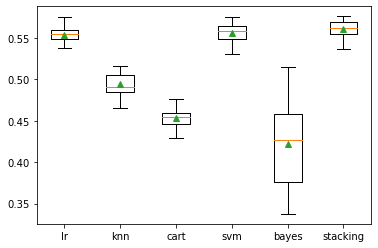

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

----------------------------------------------------
METRICS FOR TESTING DATA
Accuracy: 0.56
Detail:
              precision    recall  f1-score   support

          -1       0.57      0.67      0.62      1369
           0       0.43      0.21      0.28      1047
           1       0.58      0.71      0.64      1370

    accuracy                           0.56      3786
   macro avg       0.53      0.53      0.51      3786
weighted avg       0.54      0.56      0.53      3786



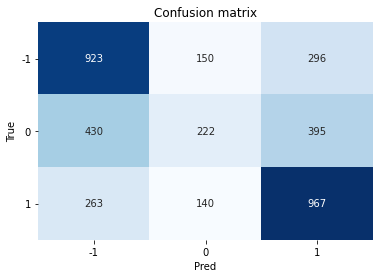

In [8]:
train_X_stage1 = train_X.iloc[:, 3:-3]
test_X_stage1 = test_X.iloc[:, 3:-3]

models = run_final_model(train_X_stage1.values, train_y.values.astype('int'), stage_number=1)
models['stacking'].fit(train_X_stage1.values, train_y.values.astype('int'))
predictions_stage1 = models['stacking'].predict(test_X_stage1.values)
test_data_metrics(test_y.values.astype('int'), predictions_stage1, stage_number=1)


In [ ]:
def load_file(file_name, file_format = '.pickle'):
    print('Loading file:', file_name, file_format, '...')
    file_path = 'data/' + file_name + file_format
    with open(file_path, 'rb') as handle:
        file = pickle.load(handle)
    return file
models = {}
models['stacking'] = load_file(str('models/Stacking'),file_format = '.sav')

### Architecture/Data Stage 2: ###
**Non-linguistic features:** 
- All

**Linguistic features:** 
- Reports TF-IDF values

In [ ]:
#train_X_stage2 = train_X.iloc[:, 4:-4]
#append the last column which was ignored on the previous column selection (as it was the last column and it went up to the last 4th)
#train_X_stage2['tfidf pred. proba'] = train_X['tfidf pred. proba'].values
#train_X_stage2

#test_X_stage2 = test_X.iloc[:, 4:-4]
#append the last column which was ignored on the previous column selection (as it was the last column and it went up to the last 4th)
#test_X_stage2['tfidf pred. proba'] = test_X['tfidf pred. proba'].values
#test_X_stage2

models = run_final_model(train_X_stage2.values, train_y.values.astype('int'), stage_number=2)
models['stacking'].fit(train_X_stage2.values, train_y.values.astype('int'))
predictions_stage2 = models['stacking'].predict(test_X_stage2.values)
test_data_metrics(test_y.values.astype('int'), predictions_stage2, stage_number=2)

### Architecture/Data Stage 3: ###
**Non-linguistic features:** 
- All

**Linguistic features:** 
- Polarity scores **with** negation heuristics.
- Reports TF-IDF values

In [ ]:
train_X_stage3 = train_X_stage1
train_X_stage3['tfidf pred. proba'] = train_X['tfidf pred. proba'].values
train_X_stage3

test_X_stage3 = test_X_stage1
test_X_stage3['tfidf pred. proba'] = test_X['tfidf pred. proba'].values
test_X_stage3

models = run_final_model(train_X_stage3.values, train_y.values.astype('int'), stage_number=3)
models['stacking'].fit(train_X_stage3.values, train_y.values.astype('int'))
predictions_stage3 = models['stacking'].predict(test_X_stage3.values)
test_data_metrics(test_y.values.astype('int'), predictions_stage3, stage_number=3)

### Architecture/Data Stage 4: ###
**Non-linguistic features:** 
- All

**Linguistic features:** 
- Best performing Stage (reports polarity alone, tfidf probabilities alone, or both combined)
- Twitter polarity scores (using Flair)


In [ ]:
train_X

In [ ]:
train_X_stage4 = train_X.iloc[:, 3:]
test_X_stage4 = test_X.iloc[:, 3:]

dropped_idxs = []
for i, (index, row) in enumerate(train_X_stage4.iterrows()):
    if row.isnull().any():
        dropped_idxs.append(i)
train_y.drop(train_y.index[dropped_idxs], inplace=True)
train_X_stage4.dropna(inplace=True)


dropped_idxs = []        
for i, (index, row) in enumerate(test_X_stage4.iterrows()):
    if row.isnull().any():
        dropped_idxs.append(i)
test_y.drop(test_y.index[dropped_idxs], inplace=True)
test_X_stage4.dropna(inplace=True)

models = run_final_model(train_X_stage4.values, train_y.values.astype('int'), stage_number=4)
models['stacking'].fit(train_X_stage4.values, train_y.values.astype('int'))
predictions_stage4 = models['stacking'].predict(test_X_stage4.values)
test_data_metrics(test_y.values.astype('int'), predictions_stage4, stage_number=4)